# Clustering Geolocation Data 
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

A taxi rank is just a taxicab stand, a queue area on a street or private property where taxicabs line up to wait for passengers.


## Outline

[**Exploratory Data Analysis**](#task1)

[**Visualizing Geographical Data**](#task2)

[**Clustering Strength / Performance Metric**](#task3)

[**K-Means Clustering**](#task4)

[**DBSCAN**](#task5)

[**HDBSCAN**](#task6)

[**Addressing Outliers**](#task7)

[**Reading**](#further)

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#plt.style.use('seaborn-white')
import seaborn as sns

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='task1'></a>
# Exploratory Data Analysis

In [3]:
data = pd.read_csv('Data/taxi_data.csv')

In [4]:
data.head(10)

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank
5,28.10125,-26.10605,Alexandra Main Taxi Rank
6,28.10185,-26.10537,Alexandra Main Taxi Rank
7,28.10165,-26.10479,Alexandra Taxi Rank
8,28.10151,-26.10594,Alexandra Taxi Rank
9,28.10200,-26.10576,Alexandra Taxi Rank


Let us look at duplicate longitude and latitude pairs.

In [5]:
data[data.duplicated(subset=['LON', "LAT"], keep=False) == True]

,LON,LAT,NAME
53,28.18473,-25.75557,Bosmanstraat Station Taxi Rank
56,28.18473,-25.75557,Bosmanstraat Station Taxi Rank
89,27.86528,-26.33297,"Capella Street Ext 9, Lenasia Taxi Rank"
90,27.86528,-26.33297,"Capella Street Ext 9, Lenasia Taxi Rank"
255,28.16904,-26.21203,Germiston Taxi Rank
256,28.16904,-26.21203,Germiston Taxi Rank
258,28.16865,-26.21145,Germiston Taxi Rank
262,28.16904,-26.21203,Germiston Taxi Rank
265,28.16865,-26.21145,Germiston Taxi Rank
371,27.82506,-26.31917,Lensasia Taxi Rank


Let us check null values.

In [6]:
# data.isnull().values.any()
data[data.isnull().any(axis=1)]

,LON,LAT,NAME
837,NaN,NaN,NaN


In [7]:
print(f'Before dropping NaNs and dupes\t:\tdata.shape={data.shape}')

data.dropna(how='any', inplace=True)
data.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)

print(f'After dropping NaNs and dupes\t:\tdata.shape={data.shape}')

Before dropping NaNs and dupes	:	data.shape=(838, 3)
After dropping NaNs and dupes	:	data.shape=(823, 3)


In [8]:
print(f'There are {len(data.iloc[:, 2].unique())} taxi ranks total.')
print('The 10 most popular are:')
data['NAME'].value_counts()[0:10]

There are 448 taxi ranks total.
The 10 most popular are:


Vosloorus Taxi Rank       18
Bree Taxi Rank            16
Pan African Taxi Rank     16
Noord Taxi Rank           14
Lenasia Taxi Rank         12
Westgate Taxi Rank        11
Randburg Taxi Rank        11
Germiston Taxi Rank       10
Phomolong Taxi Rank       10
Natal Spruit Taxi Rank    10
Name: NAME, dtype: int64

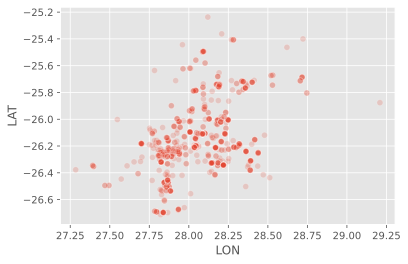

In [9]:
# X = np.array(data[['LON', 'LAT']], dtype='float64')
# plt.scatter(X[:,0], X[:,1], alpha=0.2, s=40)
sns.scatterplot(x='LON', y='LAT', data=data, alpha=0.2)

Let us visualize according to taxi rank.

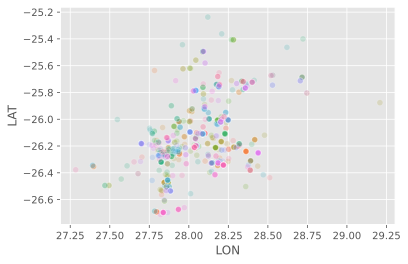

In [10]:
sns.scatterplot(x='LON', y='LAT', hue='NAME', data=data, alpha=0.2).legend_.remove()

<a id='task2'></a>
# Visualizing Geographical Data


Let us visualize our data points on a map, since we have the latitude and longitude coordinates, as opposed to using a scatterplot.

In [11]:
m = folium.Map(location=[np.average(data['LAT']), np.average(data['LON'])],
              tiles='Stamen Terrain', zoom_start=9)

In [12]:
m

In [13]:
for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+','',row['NAME']),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

Click on the blue circle points to see that point's taxi rank.

In [14]:
m

<a id='task3'></a>
# Clustering Strength / Performance Metric

In [17]:
X_blob, classes = make_blobs(n_samples=1000, centers=10,
                          cluster_std=0.5, random_state=4)

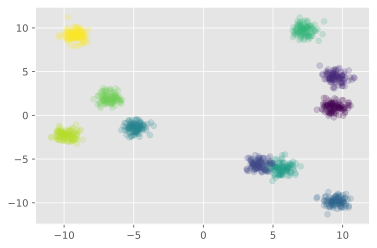

In [20]:
plt.scatter(x=X_blob[:,0], y=X_blob[:,1], c=classes, alpha=0.2)

In [21]:
class_predictions = np.load('Data/sample_clusters.npy')

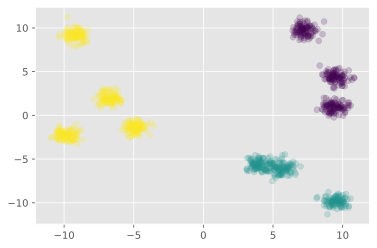

In [25]:
plt.scatter(x=X_blob[:,0], y=X_blob[:,1], c=class_predictions, alpha=0.2)

Let us use the **silhouette score**, which is the mean silhouette coefficient of all samples. The **silhouette coefficient** is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The silhouette coefficient for a sample is $\frac{b-a}{\max(a,b)}$. To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.

- $b$ = mean distance to the points in the nearest cluster

- $a$ = mean intra-cluster distance to all the points

The range of Silhouette score is $[-1, 1]$. Its analysis is as follows:

$+1$ Score − Near $+1$ Silhouette score indicates that the sample is far away from its neighboring cluster.

$0$ Score − indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.

$-1$ Score −  indicates that the samples have been assigned to the wrong clusters.

<a id='task4'></a>
# K-Means Clustering

# DBSCAN

<a id='task6'></a>
# HDBSCAN
Hierarchical DBSCAN

<a id='task7'></a>
# Addressing Outliers


<a id='further'></a>
# Reading

[K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering.

Also: [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.